In [1]:
# Importing Libs
import numpy as np

from gekko import gekko as ge # Dynamic optimization (linear, quadratic, nonlinear, and mixed integer programming)
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
def plotter(data, action, battery, net_energy, act, battery_, net_energy_, price, load, solar, wind):
    if data:
        plt.plot(price, label = 'Energy Price')
        plt.plot(load, label = 'load')
        plt.plot(solar, label = 'solar') 
        plt.plot(wind, label = 'wind')
    if action:
        plt.plot(act, label = 'Action' , color = 'black')
    if battery: 
        plt.plot(battery_, label = 'Battery')
    if net_energy: 
        plt.plot(net_energy_, label = 'Net Energy') 
    plt.legend()
    plt.show()
        
        
        
        
        

In [3]:
def calculate(optimalCost, load, price):
    costReal = 0
    steps = len(load)
    for i in range(steps):
        costReal += load[i]*price[i]
    moneySaved = costReal - optimalCost
    percentageSaved = (moneySaved/costReal)*100
    return moneySaved, percentageSaved, costReal
    

In [12]:
# Optimal Solution

def solve(steps, load, solar, price, wind, parameters):
    """ 
    parameters['battery_capacity'] = 300
    parameters['max_battery_charge_per_timestep'] = 25
    parameters['action_value'] = 1  
    parameters['sell_back_price_factor'] = 1
    parameters['initial_charge_on_battery'] = 0
    parameters['min_charge_on_battery'] = 0
    """
    
    battery_capacity = parameters['battery_capacity']
    max_battery_charge_per_timestep = parameters['max_battery_charge_per_timestep'] 
    action_value = parameters['action_value']
    sell_back_price_factor = parameters['sell_back_price_factor']
    initial_charge_on_battery = parameters['initial_charge_on_battery']
    min_charge_on_battery = parameters['min_charge_on_battery']
    emission_rate = parameters['emission_rate']
    lambda_co2 = parameters['lambda_co2']
    
    m = ge(remote=True, name='House')
    
    battery = m.Array(f = m.Var, dim = steps+1, value = initial_charge_on_battery, lb = min_charge_on_battery, ub = battery_capacity)
    action = m.Array(f = m.Var, dim=steps, value = -1, lb = -action_value, ub = action_value)
    net_energy = m.Array(f=m.Var, dim = steps, value = 0)
    
    # Net Energy
    """
    If positive --> Energy will be demanded from the grid. Here cost is incurred. 
    
    If negative --> Energy is available in excess. Can sell the energy or maybe store?
    
    """
    
    cost = m.Array(f=m.Var, dim=steps, value=0)
    equations = []
    
    # Constraint on Battery 
    equations.append(battery[0] == min_charge_on_battery)
    equations.append(battery[steps] == min_charge_on_battery)
    
    
    # Key
    """ 
    Action = 1 --> Charging the Battery
    Action = -1 --> Discharing the Battery
    """
    
    for t in range(steps):
        
        # Based on the Previous Action, Battery will be charged or discharged
        equations.append(
            battery[t+1] ==  battery[t] - action[t]*max_battery_charge_per_timestep
        )

        equations.append(
            net_energy[t] == m.sum([load[t], -solar[t], -wind[t], -action[t]*max_battery_charge_per_timestep])
            )
        
        
        cost[t] = m.if3(
            condition=net_energy[t], # When condition < 0, x1 is used, when condition >= 0, x2 is used
            x1= net_energy[t] * (price[t] * sell_back_price_factor),
            x2= net_energy[t] * (price[t])
        )
    m.Minimize(lambda_co2*m.sum(cost) + (1-lambda_co2)*m.sum(net_energy)*emission_rate)
    m.Equations(equations)
    m.solve(disp=False)

    return m.options.objfcnval, action, battery, net_energy, cost
    
    

In [5]:
# Loading the Data
data = pd.read_csv('train.csv')
load = data.load
solar = 0.24*data.solar
wind = 0.12*data.wind 
price = data.price

In [6]:
# Defining the Parameters
parameters = dict()
parameters['battery_capacity'] = 100
parameters['max_battery_charge_per_timestep'] = 20
parameters['action_value'] = 1
parameters['sell_back_price_factor'] = 0.5
parameters['initial_charge_on_battery'] = 0
parameters['min_charge_on_battery'] = 0
parameters['emission_rate'] = 50
parameters['lambda_co2'] = 0.8
steps = 1000
Ll = 100
Hl = 200
Lp = 10
Hp = 100

In [173]:
# # Data for Testing
# price = np.zeros(steps)
# load = np.zeros(steps)

# solar = np.zeros(steps)
# wind = np.zeros(steps)
# for i in range(steps//4):
#     price[i] = Lp
#     load[i] = Ll
# for i in range(steps//4, 3*steps//4):
#     price[i] = Hp
#     load[i] = Hl 
# for i in range(3*steps//4, steps):
#     price[i] = Lp
#     load[i] = Ll
    
# # Visualizing/understanding the data 
# plt.plot(load, label = 'load')
# plt.plot(solar, label = 'solar')
# plt.plot(wind, label = 'wind')
# plt.plot(price, label = 'price')
# plt.legend()
# plt.show() 


In [13]:
reward, action, battery, net_energy, cost = solve(steps, load = load, solar = solar, wind = wind, price = price, parameters = parameters)

Exception:  @error: Max Equation Length
 Error with line number:        20010
 minimize(((0.8)*(((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
 (((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
 (((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
 (((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
 (((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
 (((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
 (((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
 (((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
 (((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
 (((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
 (((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
 (((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
 (((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((0+v4008)+v
 4015)+v4022)+v4029)+v4036)+v4043)+v4050)+v4057)+v4064)+v4071)+v4078)+v4085)+v40
 92)+v4099)+v4106)+v4113)+v4120)+v4127)+v4134)+v4141)+v4148)+v4155)+v4162)+v4169
 )+v4176)+v4183)+v4190)+v4197)+v4204)+v4211)+v4218)+v4225)+v4232)+v4239)+v4246)+
 v4253)+v4260)+v4267)+v4274)+v4281)+v4288)+v4295)+v4302)+v4309)+v4316)+v4323)+v4
 330)+v4337)+v4344)+v4351)+v4358)+v4365)+v4372)+v4379)+v4386)+v4393)+v4400)+v440
 7)+v4414)+v4421)+v4428)+v4435)+v4442)+v4449)+v4456)+v4463)+v4470)+v4477)+v4484)
 +v4491)+v4498)+v4505)+v4512)+v4519)+v4526)+v4533)+v4540)+v4547)+v4554)+v4561)+v
 4568)+v4575)+v4582)+v4589)+v4596)+v4603)+v4610)+v4617)+v4624)+v4631)+v4638)+v46
 45)+v4652)+v4659)+v4666)+v4673)+v4680)+v4687)+v4694)+v4701)+v4708)+v4715)+v4722
 )+v4729)+v4736)+v4743)+v4750)+v4757)+v4764)+v4771)+v4778)+v4785)+v4792)+v4799)+
 v4806)+v4813)+v4820)+v4827)+v4834)+v4841)+v4848)+v4855)+v4862)+v4869)+v4876)+v4
 883)+v4890)+v4897)+v4904)+v4911)+v4918)+v4925)+v4932)+v4939)+v4946)+v4953)+v496
 0)+v4967)+v4974)+v4981)+v4988)+v4995)+v5002)+v5009)+v5016)+v5023)+v5030)+v5037)
 +v5044)+v5051)+v5058)+v5065)+v5072)+v5079)+v5086)+v5093)+v5100)+v5107)+v5114)+v
 5121)+v5128)+v5135)+v5142)+v5149)+v5156)+v5163)+v5170)+v5177)+v5184)+v5191)+v51
 98)+v5205)+v5212)+v5219)+v5226)+v5233)+v5240)+v5247)+v5254)+v5261)+v5268)+v5275
 )+v5282)+v5289)+v5296)+v5303)+v5310)+v5317)+v5324)+v5331)+v5338)+v5345)+v5352)+
 v5359)+v5366)+v5373)+v5380)+v5387)+v5394)+v5401)+v5408)+v5415)+v5422)+v5429)+v5
 436)+v5443)+v5450)+v5457)+v5464)+v5471)+v5478)+v5485)+v5492)+v5499)+v5506)+v551
 3)+v5520)+v5527)+v5534)+v5541)+v5548)+v5555)+v5562)+v5569)+v5576)+v5583)+v5590)
 +v5597)+v5604)+v5611)+v5618)+v5625)+v5632)+v5639)+v5646)+v5653)+v5660)+v5667)+v
 5674)+v5681)+v5688)+v5695)+v5702)+v5709)+v5716)+v5723)+v5730)+v5737)+v5744)+v57
 51)+v5758)+v5765)+v5772)+v5779)+v5786)+v5793)+v5800)+v5807)+v5814)+v5821)+v5828
 )+v5835)+v5842)+v5849)+v5856)+v5863)+v5870)+v5877)+v5884)+v5891)+v5898)+v5905)+
 v5912)+v5919)+v5926)+v5933)+v5940)+v5947)+v5954)+v5961)+v5968)+v5975)+v5982)+v5
 989)+v5996)+v6003)+v6010)+v6017)+v6024)+v6031)+v6038)+v6045)+v6052)+v6059)+v606
 6)+v6073)+v6080)+v6087)+v6094)+v6101)+v6108)+v6115)+v6122)+v6129)+v6136)+v6143)
 +v6150)+v6157)+v6164)+v6171)+v6178)+v6185)+v6192)+v6199)+v6206)+v6213)+v6220)+v
 6227)+v6234)+v6241)+v6248)+v6255)+v6262)+v6269)+v6276)+v6283)+v6290)+v6297)+v63
 04)+v6311)+v6318)+v6325)+v6332)+v6339)+v6346)+v6353)+v6360)+v6367)+v6374)+v6381
 )+v6388)+v6395)+v6402)+v6409)+v6416)+v6423)+v6430)+v6437)+v6444)+v6451)+v6458)+
 v6465)+v6472)+v6479)+v6486)+v6493)+v6500)+v6507)+v6514)+v6521)+v6528)+v6535)+v6
 542)+v6549)+v6556)+v6563)+v6570)+v6577)+v6584)+v6591)+v6598)+v6605)+v6612)+v661
 9)+v6626)+v6633)+v6640)+v6647)+v6654)+v6661)+v6668)+v6675)+v6682)+v6689)+v6696)
 +v6703)+v6710)+v6717)+v6724)+v6731)+v6738)+v6745)+v6752)+v6759)+v6766)+v6773)+v
 6780)+v6787)+v6794)+v6801)+v6808)+v6815)+v6822)+v6829)+v6836)+v6843)+v6850)+v68
 57)+v6864)+v6871)+v6878)+v6885)+v6892)+v6899)+v6906)+v6913)+v6920)+v6927)+v6934
 )+v6941)+v6948)+v6955)+v6962)+v6969)+v6976)+v6983)+v6990)+v6997)+v7004)+v7011)+
 v7018)+v7025)+v7032)+v7039)+v7046)+v7053)+v7060)+v7067)+v7074)+v7081)+v7088)+v7
 095)+v7102)+v7109)+v7116)+v7123)+v7130)+v7137)+v7144)+v7151)+v7158)+v7165)+v717
 2)+v7179)+v7186)+v7193)+v7200)+v7207)+v7214)+v7221)+v7228)+v7235)+v7242)+v7249)
 +v7256)+v7263)+v7270)+v7277)+v7284)+v7291)+v7298)+v7305)+v7312)+v7319)+v7326)+v
 7333)+v7340)+v7347)+v7354)+v7361)+v7368)+v7375)+v7382)+v7389)+v7396)+v7403)+v74
 10)+v7417)+v7424)+v7431)+v7438)+v7445)+v7452)+v7459)+v7466)+v7473)+v7480)+v7487
 )+v7494)+v7501)+v7508)+v7515)+v7522)+v7529)+v7536)+v7543)+v7550)+v7557)+v7564)+
 v7571)+v7578)+v7585)+v7592)+v7599)+v7606)+v7613)+v7620)+v7627)+v7634)+v7641)+v7
 648)+v7655)+v7662)+v7669)+v7676)+v7683)+v7690)+v7697)+v7704)+v7711)+v7718)+v772
 5)+v7732)+v7739)+v7746)+v7753)+v7760)+v7767)+v7774)+v7781)+v7788)+v7795)+v7802)
 +v7809)+v7816)+v7823)+v7830)+v7837)+v7844)+v7851)+v7858)+v7865)+v7872)+v7879)+v
 7886)+v7893)+v7900)+v7907)+v7914)+v7921)+v7928)+v7935)+v7942)+v7949)+v7956)+v79
 63)+v7970)+v7977)+v7984)+v7991)+v7998)+v8005)+v8012)+v8019)+v8026)+v8033)+v8040
 )+v8047)+v8054)+v8061)+v8068)+v8075)+v8082)+v8089)+v8096)+v8103)+v8110)+v8117)+
 v8124)+v8131)+v8138)+v8145)+v8152)+v8159)+v8166)+v8173)+v8180)+v8187)+v8194)+v8
 201)+v8208)+v8215)+v8222)+v8229)+v8236)+v8243)+v8250)+v8257)+v8264)+v8271)+v827
 8)+v8285)+v8292)+v8299)+v8306)+v8313)+v8320)+v8327)+v8334)+v8341)+v8348)+v8355)
 +v8362)+v8369)+v8376)+v8383)+v8390)+v8397)+v8404)+v8411)+v8418)+v8425)+v8432)+v
 8439)+v8446)+v8453)+v8460)+v8467)+v8474)+v8481)+v8488)+v8495)+v8502)+v8509)+v85
 16)+v8523)+v8530)+v8537)+v8544)+v8551)+v8558)+v8565)+v8572)+v8579)+v8586)+v8593
 )+v8600)+v8607)+v8614)+v8621)+v8628)+v8635)+v8642)+v8649)+v8656)+v8663)+v8670)+
 v8677)+v8684)+v8691)+v8698)+v8705)+v8712)+v8719)+v8726)+v8733)+v8740)+v8747)+v8
 754)+v8761)+v8768)+v8775)+v8782)+v8789)+v8796)+v8803)+v8810)+v8817)+v8824)+v883
 1)+v8838)+v8845)+v8852)+v8859)+v8866)+v8873)+v8880)+v8887)+v8894)+v8901)+v8908)
 +v8915)+v8922)+v8929)+v8936)+v8943)+v8950)+v8957)+v8964)+v8971)+v8978)+v8985)+v
 8992)+v8999)+v9006)+v9013)+v9020)+v9027)+v9034)+v9041)+v9048)+v9055)+v9062)+v90
 69)+v9076)+v9083)+v9090)+v9097)+v9104)+v9111)+v9118)+v9125)+v9132)+v9139)+v9146
 )+v9153)+v9160)+v9167)+v9174)+v9181)+v9188)+v9195)+v9202)+v9209)+v9216)+v9223)+
 v9230)+v9237)+v9244)+v9251)+v9258)+v9265)+v9272)+v9279)+v9286)+v9293)+v9300)+v9
 307)+v9314)+v9321)+v9328)+v9335)+v9342)+v9349)+v9356)+v9363)+v9370)+v9377)+v938
 4)+v9391)+v9398)+v9405)+v9412)+v9419)+v9426)+v9433)+v9440)+v9447)+v9454)+v9461)
 +v9468)+v9475)+v9482)+v9489)+v9496)+v9503)+v9510)+v9517)+v9524)+v9531)+v9538)+v
 9545)+v9552)+v9559)+v9566)+v9573)+v9580)+v9587)+v9594)+v9601)+v9608)+v9615)+v96
 22)+v9629)+v9636)+v9643)+v9650)+v9657)+v9664)+v9671)+v9678)+v9685)+v9692)+v9699
 )+v9706)+v9713)+v9720)+v9727)+v9734)+v9741)+v9748)+v9755)+v9762)+v9769)+v9776)+
 v9783)+v9790)+v9797)+v9804)+v9811)+v9818)+v9825)+v9832)+v9839)+v9846)+v9853)+v9
 860)+v9867)+v9874)+v9881)+v9888)+v9895)+v9902)+v9909)+v9916)+v9923)+v9930)+v993
 7)+v9944)+v9951)+v9958)+v9965)+v9972)+v9979)+v9986)+v9993)+v10000)+v10007)+v100
 14)+v10021)+v10028)+v10035)+v10042)+v10049)+v10056)+v10063)+v10070)+v10077)+v10
 084)+v10091)+v10098)+v10105)+v10112)+v10119)+v10126)+v10133)+v10140)+v10147)+v1
 0154)+v10161)+v10168)+v10175)+v10182)+v10189)+v10196)+v10203)+v10210)+v10217)+v
 10224)+v10231)+v10238)+v10245)+v10252)+v10259)+v10266)+v10273)+v10280)+v10287)+
 v10294)+v10301)+v10308)+v10315)+v10322)+v10329)+v10336)+v10343)+v10350)+v10357)
 +v10364)+v10371)+v10378)+v10385)+v10392)+v10399)+v10406)+v10413)+v10420)+v10427
 )+v10434)+v10441)+v10448)+v10455)+v10462)+v10469)+v10476)+v10483)+v10490)+v1049
 7)+v10504)+v10511)+v10518)+v10525)+v10532)+v10539)+v10546)+v10553)+v10560)+v105
 67)+v10574)+v10581)+v10588)+v10595)+v10602)+v10609)+v10616)+v10623)+v10630)+v10
 637)+v10644)+v10651)+v10658)+v10665)+v10672)+v10679)+v10686)+v10693)+v10700)+v1
 0707)+v10714)+v10721)+v10728)+v10735)+v10742)+v10749)+v10756)+v10763)+v10770)+v
 10777)+v10784)+v10791)+v10798)+v10805)+v10812)+v10819)+v10826)+v10833)+v10840)+
 v10847)+v10854)+v10861)+v10868)+v10875)+v10882)+v10889)+v10896)+v10903)+v10910)
 +v10917)+v10924)+v10931)+v10938)+v10945)+v10952)+v10959)+v10966)+v10973)+v10980
 )+v10987)+v10994)+v11001)))+((((0.19999999999999996)*((((((((((((((((((((((((((
 (((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
 (((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
 (((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
 (((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
 (((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
 (((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
 (((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
 (((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
 (((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
 (((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
 (((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
 (((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
 (((((((((((((((((((((((((((0+v2002)+v2003)+v2004)+v2005)+v2006)+v2007)+v2008)+v
 2009)+v2010)+v2011)+v2012)+v2013)+v2014)+v2015)+v2016)+v2017)+v2018)+v2019)+v20
 20)+v2021)+v2022)+v2023)+v2024)+v2025)+v2026)+v2027)+v2028)+v2029)+v2030)+v2031
 )+v2032)+v2033)+v2034)+v2035)+v2036)+v2037)+v2038)+v2039)+v2040)+v2041)+v2042)+
 v2043)+v2044)+v2045)+v2046)+v2047)+v2048)+v2049)+v2050)+v2051)+v2052)+v2053)+v2
 054)+v2055)+v2056)+v2057)+v2058)+v2059)+v2060)+v2061)+v2062)+v2063)+v2064)+v206
 5)+v2066)+v2067)+v2068)+v2069)+v2070)+v2071)+v2072)+v2073)+v2074)+v2075)+v2076)
 +v2077)+v2078)+v2079)+v2080)+v2081)+v2082)+v2083)+v2084)+v2085)+v2086)+v2087)+v
 2088)+v2089)+v2090)+v2091)+v2092)+v2093)+v2094)+v2095)+v2096)+v2097)+v2098)+v20
 99)+v2100)+v2101)+v2102)+v2103)+v2104)+v2105)+v2106)+v2107)+v2108)+v2109)+v2110
 )+v2111)+v2112)+v2113)+v2114)+v2115)+v2116)+v2117)+v2118)+v2119)+v2120)+v2121)+
 v2122)+v2123)+v2124)+v2125)+v2126)+v2127)+v2128)+v2129)+v2130)+v2131)+v2132)+v2
 133)+v2134)+v2135)+v2136)+v2137)+v2138)+v2139)+v2140)+v2141)+v2142)+v2143)+v214
 4)+v2145)+v2146)+v2147)+v2148)+v2149)+v2150)+v2151)+v2152)+v2153)+v2154)+v2155)
 +v2156)+v2157)+v2158)+v2159)+v2160)+v2161)+v2162)+v2163)+v2164)+v2165)+v2166)+v
 2167)+v2168)+v2169)+v2170)+v2171)+v2172)+v2173)+v2174)+v2175)+v2176)+v2177)+v21
 78)+v2179)+v2180)+v2181)+v2182)+v2183)+v2184)+v2185)+v2186)+v2187)+v2188)+v2189
 )+v2190)+v2191)+v2192)+v2193)+v2194)+v2195)+v2196)+v2197)+v2198)+v2199)+v2200)+
 v2201)+v2202)+v2203)+v2204)+v2205)+v2206)+v2207)+v2208)+v2209)+v2210)+v2211)+v2
 212)+v2213)+v2214)+v2215)+v2216)+v2217)+v2218)+v2219)+v2220)+v2221)+v2222)+v222
 3)+v2224)+v2225)+v2226)+v2227)+v2228)+v2229)+v2230)+v2231)+v2232)+v2233)+v2234)
 +v2235)+v2236)+v2237)+v2238)+v2239)+v2240)+v2241)+v2242)+v2243)+v2244)+v2245)+v
 2246)+v2247)+v2248)+v2249)+v2250)+v2251)+v2252)+v2253)+v2254)+v2255)+v2256)+v22
 57)+v2258)+v2259)+v2260)+v2261)+v2262)+v2263)+v2264)+v2265)+v2266)+v2267)+v2268
 )+v2269)+v2270)+v2271)+v2272)+v2273)+v2274)+v2275)+v2276)+v2277)+v2278)+v2279)+
 v2280)+v2281)+v2282)+v2283)+v2284)+v2285)+v2286)+v2287)+v2288)+v2289)+v2290)+v2
 291)+v2292)+v2293)+v2294)+v2295)+v2296)+v2297)+v2298)+v2299)+v2300)+v2301)+v230
 2)+v2303)+v2304)+v2305)+v2306)+v2307)+v2308)+v2309)+v2310)+v2311)+v2312)+v2313)
 +v2314)+v2315)+v2316)+v2317)+v2318)+v2319)+v2320)+v2321)+v2322)+v2323)+v2324)+v
 2325)+v2326)+v2327)+v2328)+v2329)+v2330)+v2331)+v2332)+v2333)+v2334)+v2335)+v23
 36)+v2337)+v2338)+v2339)+v2340)+v2341)+v2342)+v2343)+v2344)+v2345)+v2346)+v2347
 )+v2348)+v2349)+v2350)+v2351)+v2352)+v2353)+v2354)+v2355)+v2356)+v2357)+v2358)+
 v2359)+v2360)+v2361)+v2362)+v2363)+v2364)+v2365)+v2366)+v2367)+v2368)+v2369)+v2
 370)+v2371)+v2372)+v2373)+v2374)+v2375)+v2376)+v2377)+v2378)+v2379)+v2380)+v238
 1)+v2382)+v2383)+v2384)+v2385)+v2386)+v2387)+v2388)+v2389)+v2390)+v2391)+v2392)
 +v2393)+v2394)+v2395)+v2396)+v2397)+v2398)+v2399)+v2400)+v2401)+v2402)+v2403)+v
 2404)+v2405)+v2406)+v2407)+v2408)+v2409)+v2410)+v2411)+v2412)+v2413)+v2414)+v24
 15)+v2416)+v2417)+v2418)+v2419)+v2420)+v2421)+v2422)+v2423)+v2424)+v2425)+v2426
 )+v2427)+v2428)+v2429)+v2430)+v2431)+v2432)+v2433)+v2434)+v2435)+v2436)+v2437)+
 v2438)+v2439)+v2440)+v2441)+v2442)+v2443)+v2444)+v2445)+v2446)+v2447)+v2448)+v2
 449)+v2450)+v2451)+v2452)+v2453)+v2454)+v2455)+v2456)+v2457)+v2458)+v2459)+v246
 0)+v2461)+v2462)+v2463)+v2464)+v2465)+v2466)+v2467)+v2468)+v2469)+v2470)+v2471)
 +v2472)+v2473)+v2474)+v2475)+v2476)+v2477)+v2478)+v2479)+v2480)+v2481)+v2482)+v
 2483)+v2484)+v2485)+v2486)+v2487)+v2488)+v2489)+v2490)+v2491)+v2492)+v2493)+v24
 94)+v2495)+v2496)+v2497)+v2498)+v2499)+v2500)+v2501)+v2502)+v2503)+v2504)+v2505
 )+v2506)+v2507)+v2508)+v2509)+v2510)+v2511)+v2512)+v2513)+v2514)+v2515)+v2516)+
 v2517)+v2518)+v2519)+v2520)+v2521)+v2522)+v2523)+v2524)+v2525)+v2526)+v2527)+v2
 528)+v2529)+v2530)+v2531)+v2532)+v2533)+v2534)+v2535)+v2536)+v2537)+v2538)+v253
 9)+v2540)+v2541)+v2542)+v2543)+v2544)+v2545)+v2546)+v2547)+v2548)+v2549)+v2550)
 +v2551)+v2552)+v2553)+v2554)+v2555)+v2556)+v2557)+v2558)+v2559)+v2560)+v2561)+v
 2562)+v2563)+v2564)+v2565)+v2566)+v2567)+v2568)+v2569)+v2570)+v2571)+v2572)+v25
 73)+v2574)+v2575)+v2576)+v2577)+v2578)+v2579)+v2580)+v2581)+v2582)+v2583)+v2584
 )+v2585)+v2586)+v2587)+v2588)+v2589)+v2590)+v2591)+v2592)+v2593)+v2594)+v2595)+
 v2596)+v2597)+v2598)+v2599)+v2600)+v2601)+v2602)+v2603)+v2604)+v2605)+v2606)+v2
 607)+v2608)+v2609)+v2610)+v2611)+v2612)+v2613)+v2614)+v2615)+v2616)+v2617)+v261
 8)+v2619)+v2620)+v2621)+v2622)+v2623)+v2624)+v2625)+v2626)+v2627)+v2628)+v2629)
 +v2630)+v2631)+v2632)+v2633)+v2634)+v2635)+v2636)+v2637)+v2638)+v2639)+v2640)+v
 2641)+v2642)+v2643)+v2644)+v2645)+v2646)+v2647)+v2648)+v2649)+v2650)+v2651)+v26
 52)+v2653)+v2654)+v2655)+v2656)+v2657)+v2658)+v2659)+v2660)+v2661)+v2662)+v2663
 )+v2664)+v2665)+v2666)+v2667)+v2668)+v2669)+v2670)+v2671)+v2672)+v2673)+v2674)+
 v2675)+v2676)+v2677)+v2678)+v2679)+v2680)+v2681)+v2682)+v2683)+v2684)+v2685)+v2
 686)+v2687)+v2688)+v2689)+v2690)+v2691)+v2692)+v2693)+v2694)+v2695)+v2696)+v269
 7)+v2698)+v2699)+v2700)+v2701)+v2702)+v2703)+v2704)+v2705)+v2706)+v2707)+v2708)
 +v2709)+v2710)+v2711)+v2712)+v2713)+v2714)+v2715)+v2716)+v2717)+v2718)+v2719)+v
 2720)+v2721)+v2722)+v2723)+v2724)+v2725)+v2726)+v2727)+v2728)+v2729)+v2730)+v27
 31)+v2732)+v2733)+v2734)+v2735)+v2736)+v2737)+v2738)+v2739)+v2740)+v2741)+v2742
 )+v2743)+v2744)+v2745)+v2746)+v2747)+v2748)+v2749)+v2750)+v2751)+v2752)+v2753)+
 v2754)+v2755)+v2756)+v2757)+v2758)+v2759)+v2760)+v2761)+v2762)+v2763)+v2764)+v2
 765)+v2766)+v2767)+v2768)+v2769)+v2770)+v2771)+v2772)+v2773)+v2774)+v2775)+v277
 6)+v2777)+v2778)+v2779)+v2780)+v2781)+v2782)+v2783)+v2784)+v2785)+v2786)+v2787)
 +v2788)+v2789)+v2790)+v2791)+v2792)+v2793)+v2794)+v2795)+v2796)+v2797)+v2798)+v
 2799)+v2800)+v2801)+v2802)+v2803)+v2804)+v2805)+v2806)+v2807)+v2808)+v2809)+v28
 10)+v2811)+v2812)+v2813)+v2814)+v2815)+v2816)+v2817)+v2818)+v2819)+v2820)+v2821
 )+v2822)+v2823)+v2824)+v2825)+v2826)+v2827)+v2828)+v2829)+v2830)+v2831)+v2832)+
 v2833)+v2834)+v2835)+v2836)+v2837)+v2838)+v2839)+v2840)+v2841)+v2842)+v2843)+v2
 844)+v2845)+v2846)+v2847)+v2848)+v2849)+v2850)+v2851)+v2852)+v2853)+v2854)+v285
 5)+v2856)+v2857)+v2858)+v2859)+v2860)+v2861)+v2862)+v2863)+v2864)+v2865)+v2866)
 +v2867)+v2868)+v2869)+v2870)+v2871)+v2872)+v2873)+v2874)+v2875)+v2876)+v2877)+v
 2878)+v2879)+v2880)+v2881)+v2882)+v2883)+v2884)+v2885)+v2886)+v2887)+v2888)+v28
 89)+v2890)+v2891)+v2892)+v2893)+v2894)+v2895)+v2896)+v2897)+v2898)+v2899)+v2900
 )+v2901)+v2902
 
 APM model error: string >       15000  characters
 Consider breaking up the line into multiple equations
 
 The may also be due to only using newline character CR
   instead of CR LF (for Windows) or LF (for MacOS/Linux) 
 To fix this problem, save APM file with appropriate newline characters
 
 STOPPING...
 


In [175]:
temp = cost
optimalCost = 0
for i in temp:
    optimalCost += i[0]
print(optimalCost)

2057091.819395488


In [176]:
act = []
battery_ = []
net_energy_ = []
for i in range(steps):
    act.append(action[i])
    battery_.append(battery[i])
    net_energy_.append(net_energy[i])

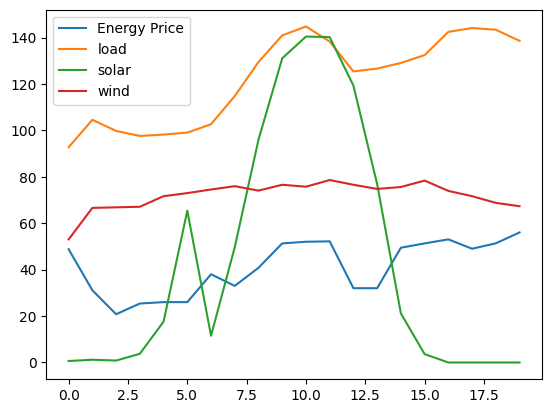

In [188]:
plotter(
    data = 1, 
    action = 0, 
    battery = 0, 
    net_energy = 0, 
    act = act[1:20], 
    battery_ = battery_[1:20], 
    net_energy_=net_energy_ , 
    load=load[:20], 
    solar=solar[:20], 
    wind=wind[:20], 
    price=price[:20]
)

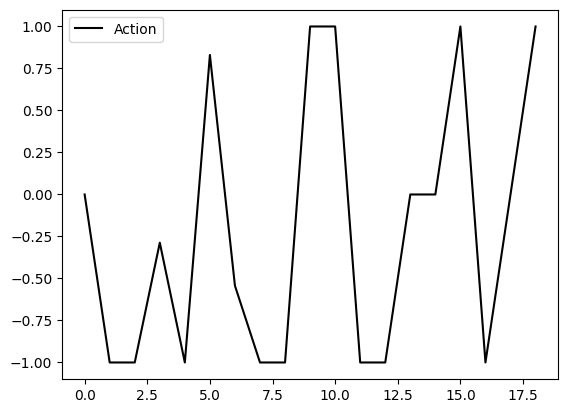

In [189]:
plotter(
    data = 0, 
    action = 1, 
    battery = 0, 
    net_energy = 0, 
    act = act[1:20], 
    battery_ = battery_[1:20], 
    net_energy_=net_energy_ , 
    load=load[:20], 
    solar=solar[:20], 
    wind=wind[:20], 
    price=price[:20]
)

In [178]:
moneySaved, percentageSaved, costReal  = calculate(optimalCost, load, price)
print('Money Saved = ', moneySaved)
print('Percentage Saved = ', percentageSaved)
print('Real Cost = ', costReal)

Money Saved =  95779633.37842822
Percentage Saved =  97.89742367680839
Real Cost =  97836725.1978237


In [187]:
# Considering Wind and Solar Generation
cost = 0
for i in range(len(data)):
    net_energy__ = load[i]-solar[i]-wind[i]
    if net_energy__ > 0:
        cost += net_energy__*price[i]
    else:
        cost -= net_energy__*price[i]*parameters['sell_back_price_factor']
print('Real Cost', cost)
print('Optimised Cost', optimalCost)
print('Money Saved', cost - optimalCost)
print('Percentage Saved', (cost - optimalCost)*100/cost)


Real Cost 58524540.270457275
Optimised Cost 2057091.819395488
Money Saved 56467448.451061785
Percentage Saved 96.48507820840774
